# PLOT FOR THR, LATENCY FOR POWER MODE TESTs

#### Globals and Imports

In [61]:
PLATFORM="Orin AGX"
POWER_MODES={'PM0': {},'PM1': {},'PM2': {}} #{'PM0': {},'PM1': {},'PM2': {}}
PATH_TO_MD="../outputs/reults_power_mode_test/orin_agx/jetson_orin_agx_resume.md"

In [62]:
import re
import matplotlib.pyplot as plt
import numpy as np

### FUNCTIONS

In [63]:
def parse_markdown_data_for_throughput(file_content):

    # la idea de esta funcion es agrupar el throupgut y la confianza en data_summary para cada plataforma, para poder luego hacer el print del grafico de los througputs
    power_mode_datas = file_content.split(f'# {PLATFORM} ')[1:]  # Divide por power mode
    data_summary = {}

    # Procesar datos principales para batch size 1 y añadir inf/s de batch size 256 cuando corresponda
    for power_mode_data in power_mode_datas:
        power_mode_saved = power_mode_data.splitlines()[0].strip()
        models_data = power_mode_data.split('## ')[1:]  # Divide por modelo y batch size, ignorando el primer split que estaría vacío
        for model_section in models_data:
            lines = model_section.split('\n')
            model_name_batch_size = lines[0].strip()
            model_name, batch_size_info = model_name_batch_size.split(' bs ')
            batch_size = int(batch_size_info.strip())

            table_data = [line for line in lines if '|' in line and 'Model' not in line]

            for data in table_data:
                if not all(char == '-' for char in data.replace('|', '').strip()):
                    cols = [col.strip() for col in data.split('|')]
                    if len(cols) > 1:
                        model_variant = cols[1]
                        inf_s_str = (cols[2].split(' ')[0].replace('.','')).replace(',','.')
                        inf_s = float(inf_s_str)
                        confianza_str_minus = (cols[2].split(' ')[3].replace('.','')).replace(',','.').replace('-','')
                        confianza_str_plus = (cols[2].split(' ')[2].replace('.','')).replace(',','.').replace('+','')
                        confianza = max(float(confianza_str_minus),float(confianza_str_plus))
                        
                        if power_mode_saved not in data_summary:
                            data_summary[power_mode_saved] = {}
                        if model_name not in data_summary[power_mode_saved]:
                            data_summary[power_mode_saved][model_name] = {}
                        if model_variant not in data_summary[power_mode_saved][model_name]:
                            data_summary[power_mode_saved][model_name][model_variant] = {}
                        data_summary[power_mode_saved][model_name][model_variant][batch_size] = inf_s, confianza

    return data_summary

In [64]:
# Función para graficar los datos de throughput (thr)
def plot_thr(data):
    # Recorrer cada red neuronal
    for network, optimizations in list(data.values())[0].items():
        # Recorrer cada optimización
        for optimization in optimizations.keys():
            plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
            plt.figure(figsize=(5, 3.5)).tight_layout()

            # Graficar los resultados para cada modo de potencia
            for power_mode, networks in data.items():
                if network not in networks:
                    continue  # Saltar si la red no está en este modo de potencia

                optim_data = networks[network][optimization]  # Datos de la optimización específica
                batch_sizes_sorted = sorted(optim_data.keys())  # Ordenar los tamaños de lote
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]  # Obtener los valores de inferencias

                # Graficar los resultados
                plt.plot(batch_sizes_sorted, infs, marker='o', label=f'{power_mode}')
            
            # Configurar los detalles del gráfico
            plt.title(f'Jetson {PLATFORM}, {network} - {optimization}')
            plt.xlabel('Batch Size')
            plt.ylabel('Throughput [inf/s]')
            plt.legend(title='Power Mode')
            plt.grid(True)
            plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
            plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
            plt.minorticks_on()
            plataforma = PLATFORM.split(' ')[1]
            plt.savefig(f'Thr_{plataforma}_{network}_{optimization}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura (opcional)
            plt.show()

In [65]:
# Función para graficar los datos de throughput (thr)
def plot_thr_juntos(data):
    # Definir los estilos de líneas y colores
    line_styles = ['-', '--', ':', '-.']
    color_map = plt.cm.get_cmap('tab10')  # Colores para los modos de potencia

    # Recorrer cada red neuronal
    for network, optimizations in list(data.values())[0].items():
        plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
        plt.figure(figsize=(6, 4)).tight_layout()

        # Graficar los resultados para cada modo de potencia
        for i, (power_mode, networks) in enumerate(data.items()):
            if network not in networks:
                continue  # Saltar si la red no está en este modo de potencia
            
            # Obtener el color para el modo de potencia
            color = color_map(i)
            all_infs = []

            # Recorrer cada optimización
            for j, (optimization, optim_data) in enumerate(networks[network].items()):
                batch_sizes_sorted = sorted(optim_data.keys())  # Ordenar los tamaños de lote
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]  # Obtener los valores de inferencias

                # Guardar las inferencias para sombrear el área entre líneas
                all_infs.append(infs)
                
                # Graficar los resultados
                plt.plot(batch_sizes_sorted, infs, marker='o', linestyle=line_styles[j % len(line_styles)],
                         color=color, label=f'{power_mode} - {optimization}')

            # Sombrar el área entre las líneas de diferentes optimizaciones para el mismo power_mode
            if len(all_infs) > 1:
                min_infs = np.min(all_infs, axis=0)
                max_infs = np.max(all_infs, axis=0)
                plt.fill_between(batch_sizes_sorted, min_infs, max_infs, color=color, alpha=0.1)

        # Configurar los detalles del gráfico
        plt.title(f'Jetson {PLATFORM}, {network}')
        plt.xlabel('Batch Size')
        plt.ylabel('Throughput [inf/s]')
        plt.legend(title='Power Mode - Optimization', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
        plt.minorticks_on()
        plataforma = PLATFORM.split(' ')[1]
        plt.savefig(f'Thr_{plataforma}_{network}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura (opcional)
        plt.show()

In [66]:
# Función para graficar los datos de throughput (thr) en una figura con múltiples subplots
def plot_thrs_red(data):
    for network, optimizations in list(data.values())[0].items():
        plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
        num_optimizations = len(optimizations.keys())
        
        # Encontrar el valor máximo de throughput (thr) para esta red
        max_thr = 0
        for power_mode, networks in data.items():
            if network not in networks:
                continue
            for optimization in optimizations.keys():
                optim_data = networks[network][optimization]
                batch_sizes_sorted = sorted(optim_data.keys())
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]
                max_thr = max(max_thr, max(infs))

        # Crear subplots en una fila con un subplot por optimización
        fig, axes = plt.subplots(1, num_optimizations, figsize=(5 * num_optimizations, 3.5))
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.05)  # Ajustar el espacio horizontal entre subplots (reducido)

        for idx, (optimization, ax) in enumerate(zip(optimizations.keys(), axes)):
            # Graficar los resultados para cada modo de potencia
            for power_mode, networks in data.items():
                if network not in networks:
                    continue  # Saltar si la red no está en este modo de potencia

                optim_data = networks[network][optimization]  # Datos de la optimización específica
                batch_sizes_sorted = sorted(optim_data.keys())  # Ordenar los tamaños de lote
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]  # Obtener los valores de inferencias

                # Graficar los resultados en el subplot correspondiente
                ax.plot(batch_sizes_sorted, infs, marker='o', label=f'{power_mode}')
            
            # Configurar los detalles del subplot
            ax.set_title(f'{optimization}')
            ax.set_xlabel('Batch Size')
            
            # Establecer el límite superior del eje Y al máximo valor de throughput
            ax.set_ylim(0, max_thr)

            # Solo el primer subplot tiene el label del eje Y
            if idx == 0:
                ax.set_ylabel('Throughput [inf/s]')
                ax.legend(title='Power Mode')  # Leyenda solo en el primer gráfico
            else:
                ax.set_ylabel('')  # No mostrar el label del eje Y
                ax.tick_params(labelleft=False)  # No mostrar los valores del eje Y
                if ax.get_legend() is not None:  # Verificar si la leyenda existe antes de eliminarla
                    ax.get_legend().remove()

            ax.grid(True)
            ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
            ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
            ax.minorticks_on()

        plataforma = PLATFORM.split(' ')[1]
        plt.suptitle(f'Jetson {PLATFORM}, {network}')  # Título general de la figura
        plt.savefig(f'Thr_{plataforma}_{network}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura (opcional)
        plt.show()


In [67]:
# Función para leer los datos del archivo .md
def read_data_from_md_for_latency(file_path):
    data = {}
    current_pm = None
    current_network = None
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            # Detectar el Power Mode
            if line.startswith(f'# {PLATFORM} PM'):
                current_pm = line.strip().split()[-1]
                if current_pm not in POWER_MODES:
                    POWER_MODES[current_pm] = {}  # Añadir a POWER_MODES si no está presente
            
            # Detectar el nombre de la red (por ejemplo, mobilenet, resnet50, etc.)
            network_match = re.match(r'## (\w+)', line)
            if network_match:
                current_network = network_match.group(1)
            
            # Leer los datos de la tabla
            table_match = re.match(r'\| (\w+)\s+\|\s+[\d.,]+.*?\|\s+([\d.,/ ]+)', line)
            if table_match and current_pm and current_network:
                model = table_match.group(1)
                latency_str = table_match.group(2).split('/')[0].strip()
                
                # Convertir la latencia a flotante
                try:
                    latency = float(latency_str.replace(',', '.'))
                except ValueError:
                    print(f"Error de conversión de latencia: '{latency_str}' en el modelo '{model}'")
                    continue
                
                # Organizar los datos en el diccionario
                if model not in data:
                    data[model] = {pm: {} for pm in POWER_MODES.keys()}
                data[model][current_pm][current_network] = latency
    return data

In [68]:
# Función para graficar los datos
def plot_model_latency(model_name, model_data):
    plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
    plt.figure(figsize=(5, 3.5)).tight_layout()

    networks = list(model_data[next(iter(POWER_MODES))].keys())  # Listado de redes

    # Crear listas de latencias para cada modo de energía definido en POWER_MODES
    latencies_by_pm = {pm: [model_data[pm].get(net, 0) for net in networks] for pm in POWER_MODES.keys()}

    # Crear gráfico de barras
    bar_width = 0.25
    index = range(len(networks))

    # Desplazar las barras para cada modo de energía
    for i, (pm, latencies) in enumerate(latencies_by_pm.items()):
        plt.bar([x + i * bar_width for x in index], latencies, bar_width, label=f'Power Mode {pm}')

    plt.title(f'Jetson {PLATFORM}, {model_name}')
    plt.xlabel('Network')
    plt.ylabel('Latency (ms)')
    plt.xticks([i + (len(POWER_MODES) - 1) * bar_width / 2 for i in index], networks)
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    # Guardar el gráfico como PDF con el nombre del modelo
    plataforma = PLATFORM.split(' ')[1]
    plt.savefig(f'latency_{plataforma}_{model_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

#### plotea el Thr.

{'PM0': {'resnet50': {'Vanilla': {1: (69.3, 4.5), 32: (354.0, 5.9), 64: (375.3, 5.3), 128: (382.8, 5.3), 256: (387.3, 3.7)}, 'TRT_fp32': {1: (121.5, 18.0), 32: (755.4, 146.2), 64: (816.3, 155.8), 128: (866.0, 105.1), 256: (870.4, 124.9)}, 'TRT_fp16': {1: (203.0, 38.7), 32: (873.0, 556.7), 64: (989.1, 514.6), 128: (1081.9, 487.6), 256: (1237.1, 363.0)}, 'TRT_int8': {1: (278.0, 65.9), 32: (965.6, 722.6), 64: (1186.5, 801.3), 128: (1347.1, 503.7), 256: (1718.0, 386.4)}}, 'resnet152': {'Vanilla': {1: (25.9, 1.0), 32: (167.2, 2.1), 64: (177.6, 2.2), 128: (180.5, 2.0), 256: (181.6, 1.2)}, 'TRT_fp32': {1: (73.3, 8.9), 32: (373.5, 3.3), 64: (402.9, 6.1), 128: (407.9, 12.7), 256: (418.5, 10.9)}, 'TRT_fp16': {1: (92.9, 8.1), 32: (690.1, 65.5), 64: (743.4, 60.6), 128: (767.3, 50.6), 256: (756.2, 63.8)}, 'TRT_int8': {1: (125.0, 11.1), 32: (853.0, 479.7), 64: (995.7, 645.2), 128: (1076.6, 464.0), 256: (1267.2, 299.8)}}}, 'PM1': {'resnet50': {'Vanilla': {1: (33.4, 1.9), 32: (75.2, 1.0), 64: (81.0, 0

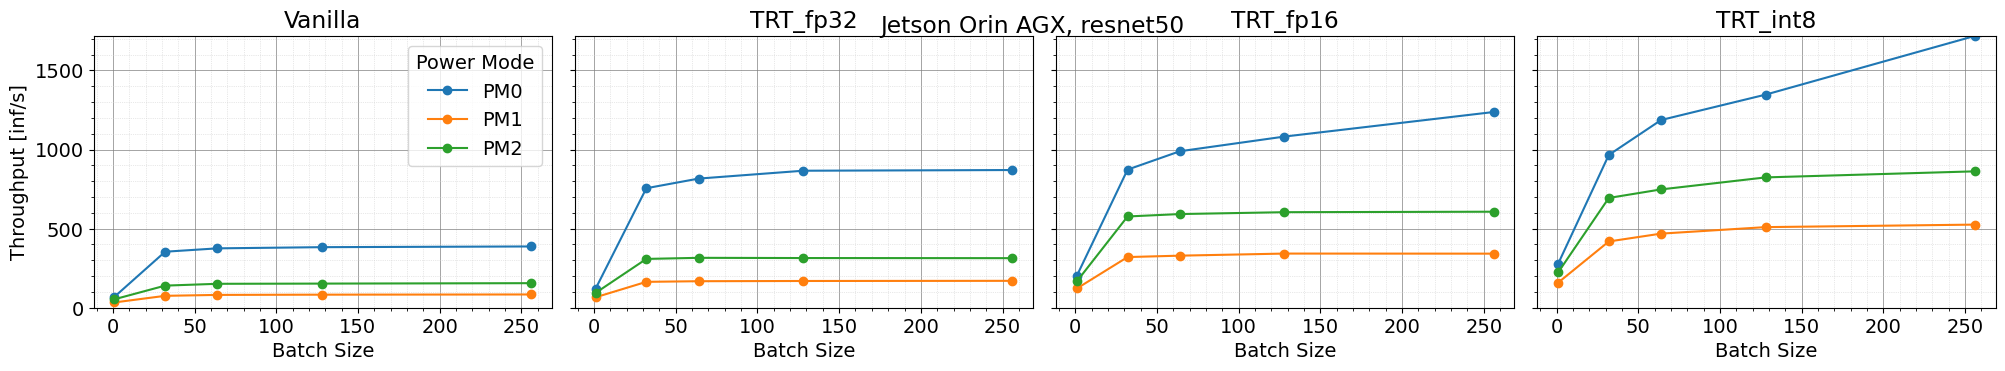

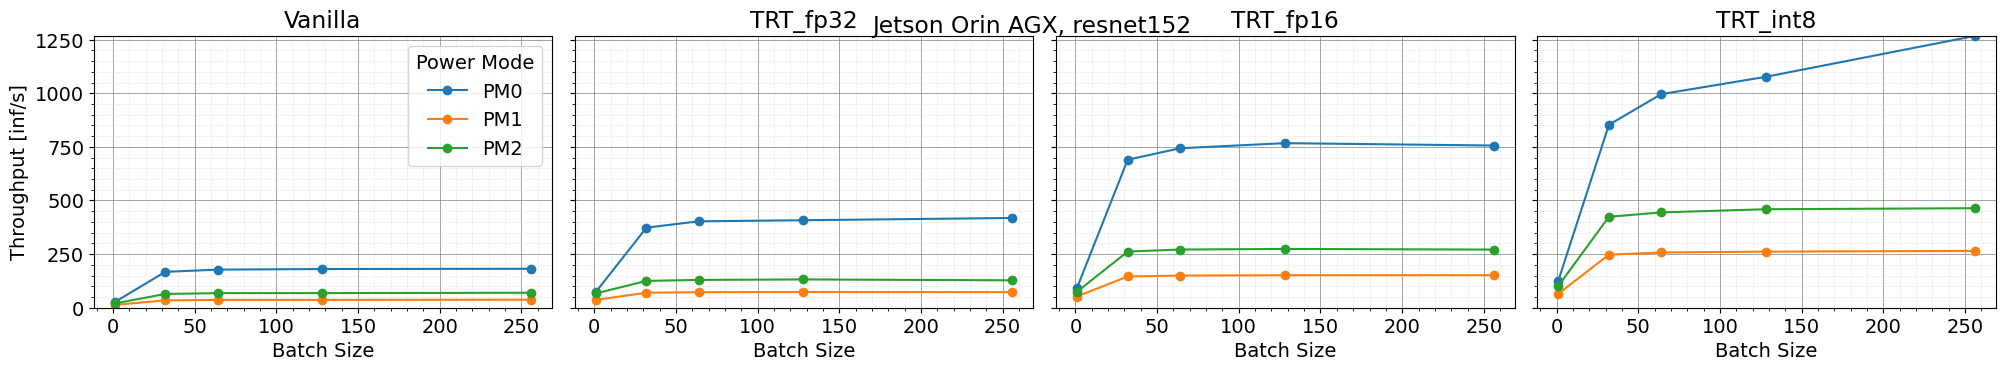

In [69]:
# Ruta del archivo .md
file_path = PATH_TO_MD

with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()

# Leer los datos del archivo .md
data_thr = parse_markdown_data_for_throughput(data)
print(data_thr)
#plot_thr(data_thr)
plot_thrs_red(data_thr)
#plot_thr_juntos(data_thr)

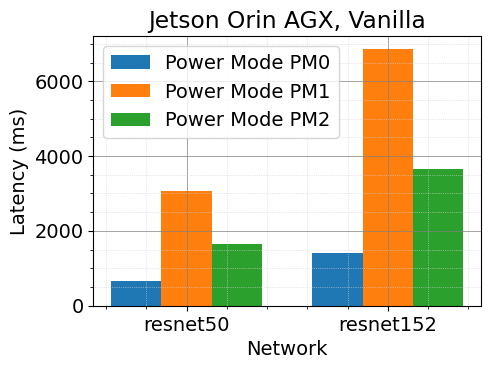

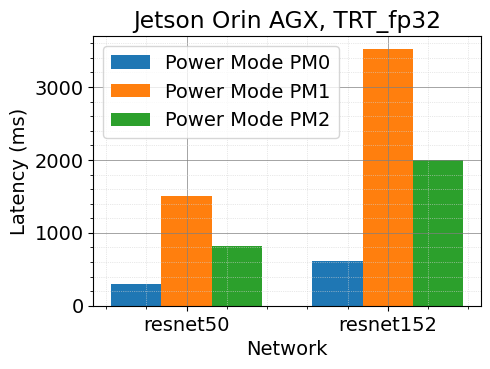

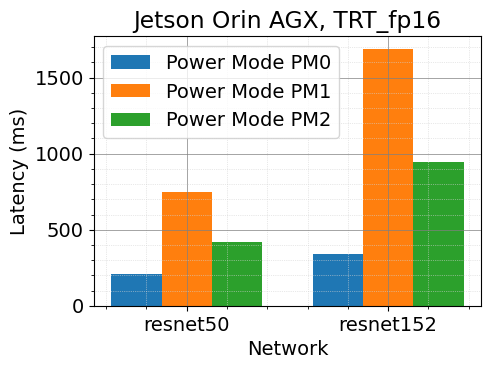

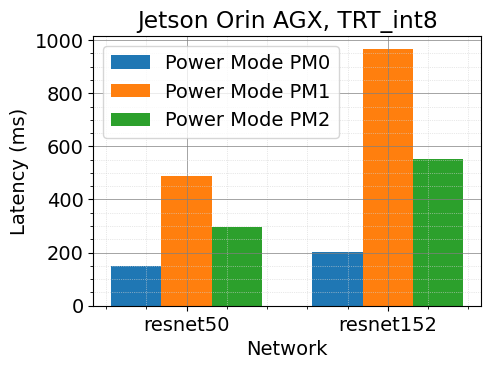

In [70]:
# Ruta del archivo .md
file_path = PATH_TO_MD

# Leer los datos del archivo .md
data = read_data_from_md_for_latency(file_path)

# Graficar cada modelo
for model_name, model_data in data.items():
    plot_model_latency(model_name, model_data)